In [1]:
import os
import h5py
import sys
sys.path.append("../..") 
import numpy as np
from cryoem.quaternions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product


In [2]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")
      
angles_true = np.array(data['Angles'])
projections = data['Projections']
      

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [3]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles.npy")

---

Alignment method: adding angles to predicted angles directly, and not multiplying rotations.

In [4]:
def lossR(a_R, a_predicted, a_true):
    ap = tf.math.add(a_predicted, a_R)
    q_predicted = euler2quaternion(ap)
    q_true = euler2quaternion(a_true)

    distance = d_q(q_true, q_predicted)
    
    return tf.reduce_mean(distance)

def gradientR(a_R, a_predicted, a_true):
    with tf.GradientTape() as tape:
        loss_value = lossR(a_R, a_predicted, a_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient

def training_angle_alignment_R(steps, batch_size, projection_idx, learning_rate, angles_true, angles_predicted, optimization=True):
    optimizer = Adam(learning_rate=learning_rate)

    losses = np.empty(steps)
    time_start = time()

    euler = np.zeros(3, dtype=np.float64)
    a_R = [tf.Variable(euler)]

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(projection_idx, size=batch_size))
        
        # Compute distances between projections
        a_true = [angles_true[i] for i in idx]
        a_predicted = [angles_predicted[i] for i in idx]
        
        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradientR(a_R, a_predicted, a_true)
            optimizer.apply_gradients(zip(gradients, a_R))
        else:
            losses[step-1] = lossR(a_R, a_predicted, a_true)

        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-(steps//10):step-1]):.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean distance difference: {np.mean(losses)}")

    return a_R, np.mean(losses[step-(steps//10):step-1])

def training_angle_alignment_R_flips(steps, batch_size, projection_idx, learning_rate, angles_true, ap, optimization=True):
    flips = {}

    # (1, -1, 1) -> loss
    for z0_flip, y1_flip, z2_flip in list(product([1, -1], repeat=3)):
    
        print(f"FLIPPING: {z0_flip, y1_flip, z2_flip}")

        ap_new = np.zeros(ap.shape)
        for i, a in enumerate(ap):
            ap_new[i] = [z0_flip*a[0], y1_flip*a[1], z2_flip*a[2]]
            
        angles_predicted = tf.convert_to_tensor(ap_new)

        a_R, loss = training_angle_alignment_R(steps=steps, 
                                    batch_size=batch_size,
                                    projection_idx=projection_idx,
                                    learning_rate=learning_rate,
                                    angles_true=angles_true,
                                    angles_predicted=angles_predicted,
                                    optimization=True)
        
        print(f"Rotation: {a_R[0].numpy()};  Loss: {loss}")
        flips[(z0_flip, y1_flip, z2_flip)] = (a_R, loss)
    
    best_flips = min(flips, key=lambda x: flips.get(x)[1])
    return best_flips, flips[best_flips]

def updateR_alignment(flips, ap, a_R):
    ap_new = np.zeros(ap.shape)
    for i, a in enumerate(ap):
        ap_new[i] = [flips[0]*a[0], flips[1]*a[1], flips[2]*a[2]]

    angles_predicted = tf.convert_to_tensor(ap_new)

    q_predicted = euler2quaternion(angles_predicted)
    q_R = euler2quaternion(a_R)

    angles_predicted_new = quaternion2euler(quaternion.multiply(q_predicted, q_R))
    return angles_predicted_new

def distance_difference(angles_predicted, angles_true):
    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)
    qd = np.mean(d_q(q_predicted, q_true).numpy())
    print(f"Mean quaternion distance between true and predicted values: {qd} rad ({np.degrees(qd):.2f} degrees)")

    return qd


In [5]:
distance_difference(ap, angles_true);

Mean quaternion distance between true and predicted values: 1.8203037587990536 rad (104.30 degrees)


FLIPPING: (1, 1, 1)
step 1000/10000 (62s): loss = 1.81e+00
step 2000/10000 (122s): loss = 1.80e+00
step 3000/10000 (184s): loss = 1.80e+00
step 4000/10000 (245s): loss = 1.81e+00
step 5000/10000 (309s): loss = 1.81e+00
step 6000/10000 (372s): loss = 1.80e+00
step 7000/10000 (435s): loss = 1.81e+00
step 8000/10000 (503s): loss = 1.81e+00
step 9000/10000 (568s): loss = 1.80e+00
step 10000/10000 (634s): loss = 1.81e+00
Rotation: [ 1.30460189 -0.13881971  0.64301416];  Loss: 1.8059127340227028
FLIPPING: (1, 1, -1)
step 1000/10000 (65s): loss = 1.56e+00
step 2000/10000 (131s): loss = 1.56e+00
step 3000/10000 (196s): loss = 1.56e+00
step 4000/10000 (262s): loss = 1.56e+00
step 5000/10000 (326s): loss = 1.55e+00
step 6000/10000 (389s): loss = 1.56e+00
step 7000/10000 (453s): loss = 1.56e+00
step 8000/10000 (514s): loss = 1.56e+00
step 9000/10000 (575s): loss = 1.55e+00
step 10000/10000 (637s): loss = 1.56e+00
Rotation: [ 1.77026620e+00  1.03457350e-03 -1.92411812e-01];  Loss: 1.55587053144986

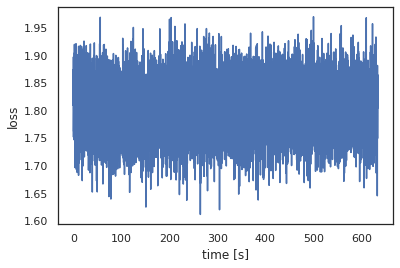

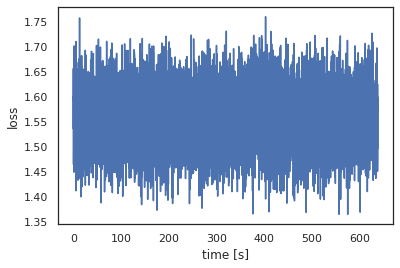

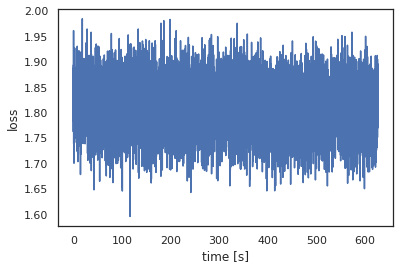

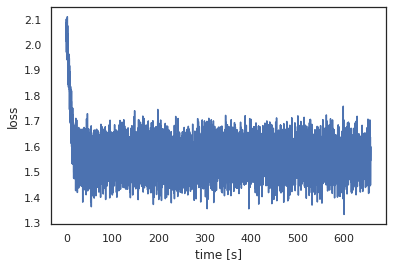

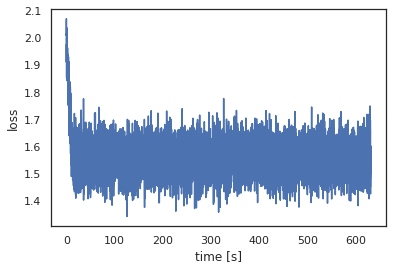

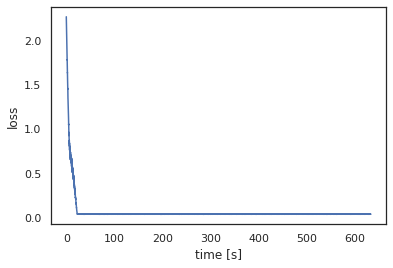

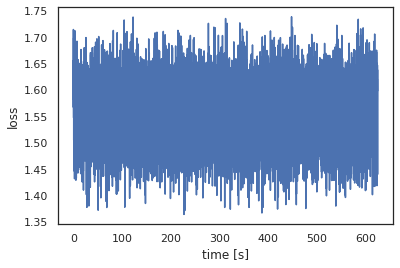

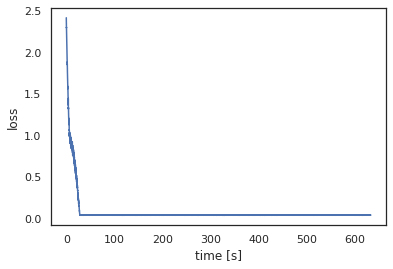

In [6]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=10000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [9]:
flips, (a_R, loss)

((-1, 1, -1),
 ([<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([ 2.42507828e+00,  6.49478306e-04, -2.11279940e-01])>],
  0.03807980045359422))

In [8]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [10]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Mean quaternion distance between true and predicted values: 1.185072951673217 rad (67.90 degrees)


1.185072951673217

---

---

\begin{equation}
\label{eq:phase1}
\operatorname*{min}_{R  \in SO(4), m \in \{-1,1\}} \frac{1}{n} \sum_{i=1} d_r(\begin{bmatrix}
1 & 0\\
0 & R_i
\end{bmatrix}, R \begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} \begin{bmatrix}
1 & 0\\
0 & \hat{R_i}
\end{bmatrix})
\end{equation}

- $d_R$ is the distance between two rotation matrices:

\begin{equation}
\label{eq:phase2}
 d_r(R_1, R_2) = \arccos{\frac{tr(R_1 R_2^T)-1}{2}}
\end{equation}

- $R_i \in SO(3)$ is the rotation matrix of a true rotation angles

- $\hat{R_i} \in SO(3)$ is the rotation of the estimatied rotation angles

- $R \in SO(4)$ is $4x4$ orthogonal matrix with determinant 1 that represents a global rotation

- $m \in \{-1,1\}$ represents a global reflection ($m=1$ no reflection, $m=-1$ reflection)

- $\begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} = \begin{bmatrix}
m & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$

In [11]:
def euler2matrix(angles):
    angles = tf.convert_to_tensor(angles)
    c1 = tf.reshape(tf.math.cos(angles[:,0]), (-1,1,1))
    c2 = tf.reshape(tf.math.cos(angles[:,1]), (-1,1,1))
    c3 = tf.reshape(tf.math.cos(angles[:,2]), (-1,1,1))
                
    s1 = tf.reshape(tf.math.sin(angles[:,0]), (-1,1,1))
    s2 = tf.reshape(tf.math.sin(angles[:,1]), (-1,1,1))
    s3 = tf.reshape(tf.math.sin(angles[:,2]), (-1,1,1))
     
    R = tf.concat([tf.concat([c1*c2*c3-s1*s3, c1*s3+c2*c3*s1 , -c3*s2],axis=2),\
                    tf.concat([-c3*s1-c1*c2*s3,    c1*c3-c2*s1*s3 ,   s2*s3],axis=2),\
                    tf.concat( [c1*s2,             s1*s2          ,   c2],axis=2)],axis=1)
    return R

def d_R(M1, M2):
    """Distance between 2 rotation matirces"""
    R = tf.linalg.matmul(M1, M2, transpose_b=True)
    mid = (tf.linalg.trace(R)-1)/2
    mid = tf.clip_by_value(mid, -1, 1)
    return tf.math.acos(mid)

In [229]:
def euler6tomarix4d(a_R):
    a, b, g, l, t, p = tf.unstack(a_R, axis=-1)
    
    ca = tf.cos(a)
    cb = tf.cos(b)
    cg = tf.cos(g)
    cl = tf.cos(l)
    ct = tf.cos(t)
    cp = tf.cos(p)
    
    sa = tf.sin(a)
    sb = tf.sin(b)
    sg = tf.sin(g)
    sl = tf.sin(l)
    st = tf.sin(t)
    sp = tf.sin(p)

    
#     rotmat = tf.constant((4,4))
    
#     rotmat[0,0] = cp*ct*cl
#     rotmat[0,1] = -1j*cp*ct*cl
#     rotmat[0,2] = -1j*st*cp
#     rotmat[0,3] = -1j*sp
    
#     rotmat[1,0] = 1j*cb*(sg*st*cl - cg*sl) - 1j*sb*sp*ct*cl
#     rotmat[1,1] = cb*(cg*cl + sg*st*sl) - sb*sp*ct*sl
#     rotmat[1,2] = -sb*st*sp - cb*sg*ct
#     rotmat[1,3] = sb*cp
    
#     rotmat[2,0] = -1j*ca*(sg*sl+cg*st*cl)-1j*sa(-sb*(sg*st*cl-cg*sl)-cb*sp*ct*cl)
#     rotmat[2,1] = ca*(sg*cl-cg*st*sl)-sa(-sb*(cg*cl+sg*st*sl)-cb*sp*ct*sl)
#     rotmat[2,2] = ca*cg*ct+sa*(-sb*sg*ct+cb*st*sp)
#     rotmat[2,3] = -sa*cb*cp
    
#     rotmat[3,0] = -1j*sa*(sg*sl+cg*st*cl)+1j*ca*(-sb*(sg*st*cl-cg*sl)-cb*sp*ct*cl)
#     rotmat[3,1] = sa*(sg*cl-cg*st*sl) - ca*(-sb*(cg*cl+sg*st*sl) - cb*sp*ct*sl)  # TODO; check the sign here
#     rotmat[3,2] = sa*cg*ct - ca*(-sb*sg*ct + cb*st*sp)
#     rotmat[3,3] = ca*cb*cp
    #print(tf.concat([ [tf.complex(1.0, 0.0)], [tf.complex(0.0, 0.0)], [tf.complex(0.0, 0.0)], [tf.complex(0.0, 0.0)]], axis=0))
#     a = tf.concat([ [tf.complex(1.0, 0.0)], [tf.complex(0.0, 0.0)], [tf.complex(0.0, 0.0)], [tf.complex(0.0, 0.0)]], axis=0)
    
#     print(tf.complex([0.0], 0.0))
#     print(tf.complex( ca, 0.0))
    
#     print(tf.concat([ [tf.concat([ [tf.complex(1.0, 0.0)], [tf.complex(0.0, 0.0)], [tf.complex(0.0, 0.0)], [tf.complex(0.0, 0.0)]], axis=0)],
#                       [tf.concat([ [tf.complex(1.0, 0.0)], [tf.complex(0.0, 0.0)], [tf.complex(0.0, 0.0)], [tf.complex(0.0, 0.0)]], axis=0)], 
#                       [tf.concat([ [tf.complex(1.0, 0.0)], [tf.complex(0.0, 0.0)], [tf.complex(0.0, 0.0)], [tf.complex(0.0, 0.0)]], axis=0)]],axis=0))
    
#     print(tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
#                       [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
#                       [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex( ca, 0.0), tf.complex(-sa, 0.0)], axis=0)],
#                       [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex( sa, 0.0), tf.complex(ca, 0.0)],  axis=0)]], axis=0))

    Ra = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(   ca, 0.0), tf.complex(  -sa, 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(   sa, 0.0), tf.complex(   ca, 0.0)], axis=0)]], axis=0)
    print(Ra)
    print(cb, -sb, )
    Rb = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex(   cb, 0.0), tf.complex([0.0], 0.0), tf.complex(   sb, 0.0)], axis=0)]
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)]
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex(  -sb, 0.0), tf.complex([0.0], 0.0), tf.complex(   cb, 0.0)], axis=0)]], axis=0)
    print(Rb)
    Rg = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex( cg, 0.0), tf.complex(-sg, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex( sg, 0.0), tf.complex( cg, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rl = tf.concat([ [tf.concat([ tf.complex( cl, 0.0), tf.complex([0.0], -sl), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -sl), tf.complex( cl, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rt = tf.concat([ [tf.concat([ tf.complex( ct, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], -st), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -st), tf.complex([0.0], 0.0), tf.complex( ct, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rp = tf.concat([ [tf.concat([ tf.complex( cp, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], -sp)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -sp), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(cp, 0.0)], axis=0)]], axis=0)
    
    R = Ra @ Rb @ Rg @ Rl @ Rt @ Rp
    
    
    return R
    
    

def from3to4(mat):
    fill1 = tf.reshape([[0.0,0.0,0.0]]*mat.shape[0], (-1,3,1))
    mat_4d = tf.concat([fill1, mat], axis=2)
    fill2 = tf.reshape([[1.0,0.0,0.0,0.0]]*mat_4d.shape[0], (-1,1,4))
    return tf.concat([fill2, mat_4d], axis=1)


def loss_alignment(m, a_R, a_predicted, a_true):
    Ri = tf.cast(euler2matrix(a_true), dtype=tf.float32)
    Ri_est = tf.cast(euler2matrix(a_predicted), dtype=tf.float32)
    
    Ri_4d = from3to4(Ri)
    Ri_est_4d = from3to4(Ri_est)
    #R_4d = from3to4(R)
    R = euler6tomarix4d(a_R) #tf.cast(euler2matrix(a_R), dtype=tf.float32)
    
    identity = tf.constant([[m, 0,0,0],[0,1,0,0],[0,0,1,0], [0,0,0,1]], dtype=tf.float32)
    
    second = R @ identity @ Ri_est_4d
    
    distance = d_R(Ri_4d, second)
    
    return tf.reduce_mean(distance)


def gradient_alignment(m, a_R, a_predicted, a_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, a_predicted, a_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(steps, batch_size, projection_idx, learning_rate, angles_true, angles_predicted, optimization=True):
    optimizer = Adam(learning_rate=learning_rate)
    
    time_start = time()

    # collect rotations
    r = []
    # collect losses depending on rotation
    l = []

    for m in [-1,1]:
        losses = np.empty(steps)
        angles_predicted = tf.convert_to_tensor(ap)
    
        euler = np.zeros(6, dtype=np.float32)
        a_R = [tf.Variable(euler)]
        
        for step in range(1, steps+1):

            # Sample some pairs.
            idx = list(np.random.choice(projection_idx, size=batch_size))

            # Compute distances between projections
            a_true      = [angles_true[i]      for i in idx]
            a_predicted = [angles_predicted[i] for i in idx]

            # Optimize by gradient descent.
            if optimization:
                losses[step-1], gradients = gradient_alignment(m, a_R, a_predicted, a_true)
                optimizer.apply_gradients(zip(gradients, a_R))
            else:
                losses[step-1] = loss_alignment(m, a_R, a_predicted, a_true)

            # Periodically report progress.
            if ((step % (steps//10)) == 0) or (step == steps):
                time_elapsed = time() - time_start
                print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')
        print("-"*20)
        if optimization:
            # Plot convergence.
            fig, ax = plt.subplots()
            ax.plot(np.linspace(0, time()-time_start, steps), losses)
            ax.set_xlabel('time [s]')
            ax.set_ylabel('loss');
        else:
            print(f"Mean distance difference: {np.mean(losses)}")
         
        r.append(a_R)
        l.append(losses[-1])
        
    for i, m in enumerate([-1, 1]):
        print(f"For m={m}, loss is: {l[i]}")
    
    idx_best = np.argmin(np.array(l))
    return r[idx_best], l[idx_best]


In [230]:
rotation, loss = training_angle_alignment(steps=10000, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap, 
                         optimization=True)

tf.Tensor(
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]], shape=(4, 4), dtype=complex64)
tf.Tensor([1.], shape=(1,), dtype=float32) tf.Tensor([-0.], shape=(1,), dtype=float32)


TypeError: only integer scalar arrays can be converted to a scalar index